In [62]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)

# Track Finding and Fitting

## Tracking in TPCs

### Hough Transform

### RANSAC

## Facility Location Problem
The previously explored methods of the Hough Transform and RANSAC are both _greedy_ methods; the order in which solutions are generated favours those models which are found first. The consequence of greedy optimisation is that the global solution across several models may not be optimal.

:::{admonition} To Do
Give a visual example of this
:::

In order obtain a _global_ solution to track labelling, the task must be reframed as a global optimisation problem. 
The facility location problem (FLP) is an optimization problem whose solution determines the optimal location for a set of facilities such that the transportation costs for each facility are minimised. There are several formulations of the problem with auxillary constraints, such as the _capacity_ of the facilities, or the addition of an _opening cost_ for each facility. 

The significance of "facility" and "transportation cost" depends upon the framing of the problem. Here, the _uncapacitated facility location problem_ (UFLP) will be explored in the context of particle track labelling.

### Uncapacitated Facility Location Problem
The uncapacitated facility location problem is a variant of the FLP in which each facility has an unlimited capacity and an associated opening cost. In prose, the problem may be defined by the following requirements
- A manufacturing company wants to minimise costs.
- Delivery is expensive, so facilities need to be close to consumers.
- Facilities are also expensive, so as few as possible should be opened.

The solution to this problem is given by the minimisation of the following cost function: 
:::{math}
:label: uflp-cost-function
E(F) = \sum_{f \in F} \left( O_f + \sum_{c \in C} T_{fc} D_{fc} \right)\,,
:::
where 
- {math}`F` is the set of open facilities.
- {math}`O_f` is the cost of opening facility {math}`f`.
- {math}`T_{fc}` is the cost of transporting goods between facility {math}`f` and consumer {math}`c`.
- {math}`D_{fc}` is the demand of consumer {math}`c` satisfied by facility {math}`f`.


In the domain of track labelling, the terms "facility", "distance", and "consumer", acquire new meaning:
```{list-table} Terms corresponding to the FLP interpretation of track labelling.
:name: flp-labelling-terms
:header-rows: 1

* - Term
  - Interpretation
* - Facility
  - A hypothetical track model
* - Consumer
  - An observation that belongs to an unknown track model
* - Transport cost
  - The goodness-of-fit for an observation given a particular track model
```

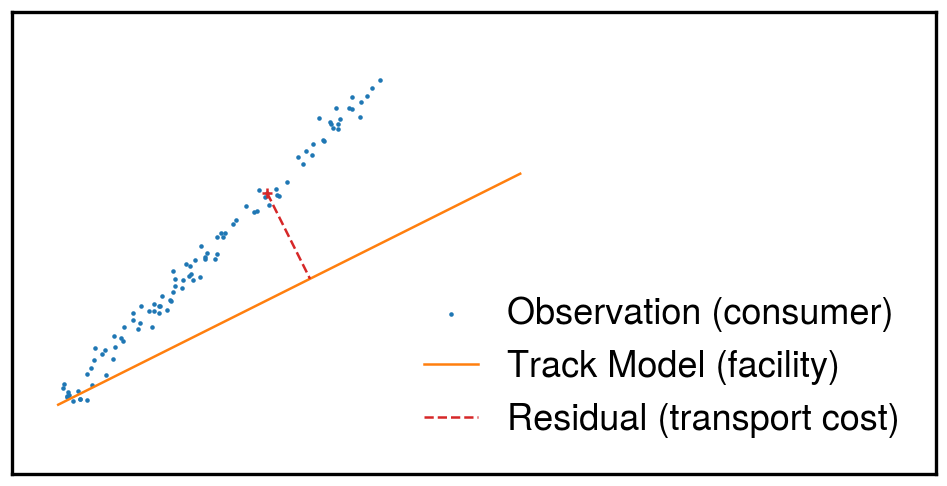

In [91]:
plt.figure()

n = 100

t = np.random.uniform(high=10.0, size=n)
w = np.random.normal(scale=0.15, size=n)
R = np.stack((t, w), axis=1)

x = np.radians(45)
M = np.sin([[np.pi / 2 - x, -x], [x, np.pi / 2 - x]])
S = R @ M.T

# Draw scatter
plt.scatter(S[:, 0], S[:, 1], s=3, label="Observation (consumer)")

# Draw model
Q = np.r_[10, 5]
plt.plot([0, Q[0]], [0, Q[1]], color="C1", label="Track Model (facility)")

# Random midpoint
i_midpoint = np.argmin(np.abs(S[:, 0] - 4.5))
P = S[i_midpoint]
plt.scatter(P[0], P[1], marker="+", color="C3")

# Intersection
tau = ((P - [0, 0]) @ Q) / (Q @ Q)
H = tau * Q

# Draw tangent
plt.plot([P[0], H[0]], [P[1], H[1]], color="C3", linestyle="--", label="Residual (transport cost)")

plt.gca().set_aspect(1)
plt.xlim(-5+4, 15+4)
plt.ylim(-1.5, 8.5)
plt.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    top=False,
    right=False,
    labelbottom=False,
    labelleft=False,
)
plt.legend();

Meanwhile, the consumer demand {math}`D_{fc}` is simply the delta function of the labelling {math}`\delta_{ff(c)}`, i.e. a single observation {math}`c` is served by exactly one facility {math}`f(c)`.

The probability of observing set {math}`C` of observations for facility $f$ is the product of the probabilities of observing each $c$, i.e. 
:::{math}
P(f \mid C) = \prod_c{P(f \mid c)}\,.
:::
If the per-consumer transport cost is given as a log-likelihood, then it follows that the sum over the transport costs for each facility is equivalent to the log-likelihood of the facility given {math}`C`:
:::{math}

\sum_c{\ln\left({P(f \mid c)}\right)} 
&= \ln\left({\prod_c{P(f \mid c)}}\right)

&= \ln\left(P(f \mid C)\right)\,.
:::

### Metric Labelling Problem

The trivial form of {eq}`uflp-cost-function`, in which the facility cost {math}`O_f` is zero
:::{math}
:label: cost-function-trivial
E(F) = \sum_{f \in F,\,c \in C} T_{fc} D_{fc}\,,
:::
is ill-posed. A _well-posed_ problem is guaranteed to have a _unique_ solution that depends continuously on the input data.{cite:ps}`hadamard`

In order to solve {eq}`cost-function-trivial`, the set of admissable solutions must be restricted by the introduction of _a priori_ knowledge, i.e. the problem must be _regularised_. The label cost term given in {eq}`uflp-cost-function` is one such regulariser which imposes a preference for solutions with fewer labels.

A common feature of the labelling problem (of which the track labelling problem is a derivative) is that coherent groups of observations are typically known _a priori_ to be positively correlated. This behaviour can be accounted for by an additional regulariser in the energy function
:::{math}
\sum_{cc'\in C}V(f(c),f(c'))\,,
:::
where {math}`V(f(c),f(c'))` is the pairwise prior that penalises {math}`f(c) \neq f(c')`, such that we have
:::{math}
:label: cost-function-pearl
E(F) = 
\underbrace{\sum_{f \in F} O_f}_{\text{label cost}} + 
\underbrace{\sum_{f \in F,\,c \in C} T_{fc} D_{fc}}_{\text{data cost}} + 
\underbrace{\sum_{cc'\in C}V(f(c),f(c'))}_{\text{smooth cost}}\,.
:::

Clearly, the _label cost_ leads to minimisation of the model count, whilst the _smooth cost_ leads to the preference of spatially coherent labellings. As before, the _data cost_ prefers models which are well-described by their inliers.

### Graph Cut Optimization

Though the task of minimising {eq}`cost-function-pearl` is NP-hard for {math}`\lvert F \rvert \geq 3`,{cite:ps}`boykov_fast_2001-1`,  there exist approximate solutions using _graph cuts_ that are guaranteed to find the local minima within a fixed bound of the global optimum.{cite:ps}`delong_fast_2010`.

:::{note}
In computational complexity theory, _P_ problems are those problems of size {math}`n` for which the time {math}`T(n)` to determine their solutions is upper bounded by a polynomial in {math}`n`, i.e. {math}`T(n)=\mathcal{O}(n^k)`

_NP_ problems are those which cannot be _solved_ but can be _verified_ in polynomial time.

_NP-complete_ problems are NP problems to which all other NP problems can be reduced in polynomial time.

_NP-hard_ problems are _at least_ as complex as NP-complete problems, i.e. there must exist an NP-complete problem that can be transformed in polynomial time to an NP-hard problem.

:::{figure} https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/P_np_np-complete_np-hard.svg/640px-P_np_np-complete_np-hard.svg.png
---
name: p-np-complete
alt: Diagram illustrating the relationship between P, NP, NP-complete, and NP-hard problems under the assumptions of {math}`P=NP` and {math}`P\neq NP`
width: 512px
align: center
figclass: margin
---
:::

### PeARL

## Kinematic Fitting

:::{note}
Should we look at GNN / CA methods here?
:::